In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *
import lal
lal.swig_redirect_standard_output_error(False)
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

from constants import *
import equations
import redshiftPrior

In [2]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize': fontsize,
   'lines.linewidth': 1,  
   'xtick.direction': 'in',
   'ytick.direction': 'in',
   'font.family': 'Serif',
   'font.serif': 'Hoefler Text',
   'axes.grid': True,
   'figure.figsize': (6.75, 4),
   'figure.dpi': 250,
   'mathtext.fontset': 'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [3]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Data Simulation Parameters
T_obs = (10/365.25) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
fs = 2048 # sampling rate (in Hz)

num_iterations = 50

In [4]:
from bilby.gw.prior import AlignedSpin
class SpinPrior():
    '''
    Realistic spin distribution probabilities from Callister and Farr
    ''' 
    def __init__(self, minimum, maximum, **kwargs):
        self.minimum = minimum
        self.maximum = maximum
        # super(SpinPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)

    def _get_chi_arrays(self):
        chi0 = 0.15
        gamma = 0.18
        f_iso = 0.67
        mu = 0.59
        sigma = 0.58

        chis = np.linspace(self.minimum, self.maximum, 1000)
        C = (math.atan((1-chi0)/gamma) + math.atan(chi0/gamma))**(-1)
        pchis = (C/gamma)*(1+((chis-chi0)/gamma)**2)**(-1)
        return chis, pchis

    def sample(self, N):
        chis, pchis = self._get_chi_arrays()
        max_pchi = np.max(pchis)
        total = 0
        samples = []
        a = []
        b = []
        c = []
        d = []
        while total < N:
            chiIndex = random.randint(1000)
            chi = chis[chiIndex]
            pchi = random.rand()*max_pchi
            if(pchi < pchis[chiIndex]):
                samples.append(chi)
                total = total + 1
                a.append(chi)
                b.append(pchi)
            else:
                c.append(chi)
                d.append(pchi)
        fig, ax = plt.subplots()
        ax.scatter(a, b, s=0.5, color='g')
        ax.scatter(c, d, s=0.5, color='r')
        ax.plot(chis, pchis, color='b')
        # ax.set_xlim(0, 1)
        return samples
    
class ThetaPrior():
    '''
    Theta distribution prior from Callister and Farr
    '''
    def __init__(self, minimum, maximum, **kwargs):
        self.minimum = minimum
        self.maximum = maximum
        # super(ThetaPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)

    def phi(self, xi):
            return (1/math.sqrt(2*math.pi))*math.exp(-(1/2)*xi**2)
    
    def Phi(self, x):
            return (1/2)*(1+math.erf(x/math.sqrt(2)))
    
    def _get_costheta_arrays(self):
        chi0 = 0.15
        gamma = 0.18
        f_iso = 0.67
        mu = 0.59
        sigma = 0.58

        a = self.minimum
        b = self.maximum

        costhetas = np.linspace(0, 2*math.pi, 1000)
        pcosthetas = []
        for costheta in costhetas:
            Nab = (1/sigma)*(self.phi((costheta-mu)/sigma))/(self.Phi((b - mu)/sigma) - self.Phi((a - mu)/sigma))
            pcostheta = f_iso/2 + (1 - f_iso)*Nab
            pcosthetas.append(pcostheta)
        return costhetas, pcosthetas

    def sample(self, N):
        costhetas, pcosthetas = self._get_costheta_arrays()
        max_pcostheta = np.max(pcosthetas)
        total = 0
        samples = []
        a = []
        b = []
        c = []
        d = []
        while total < N:
            costhetaIndex = random.randint(1000)
            costheta = costhetas[costhetaIndex]
            pcostheta = random.rand()*max_pcostheta
            if(pcostheta < pcosthetas[costhetaIndex]):
                samples.append(pcostheta)
                total = total + 1
                a.append(costheta)
                b.append(pcostheta)
            else:
                 c.append(costheta)
                 d.append(pcostheta)
        fig, ax = plt.subplots()
        ax.scatter(a, b, s=0.5, color='g')
        ax.scatter(c, d, s=0.5, color='r')
        ax.plot(costhetas, pcosthetas, color='b')
        # ax.set_xlim(-1, 1)
        return samples

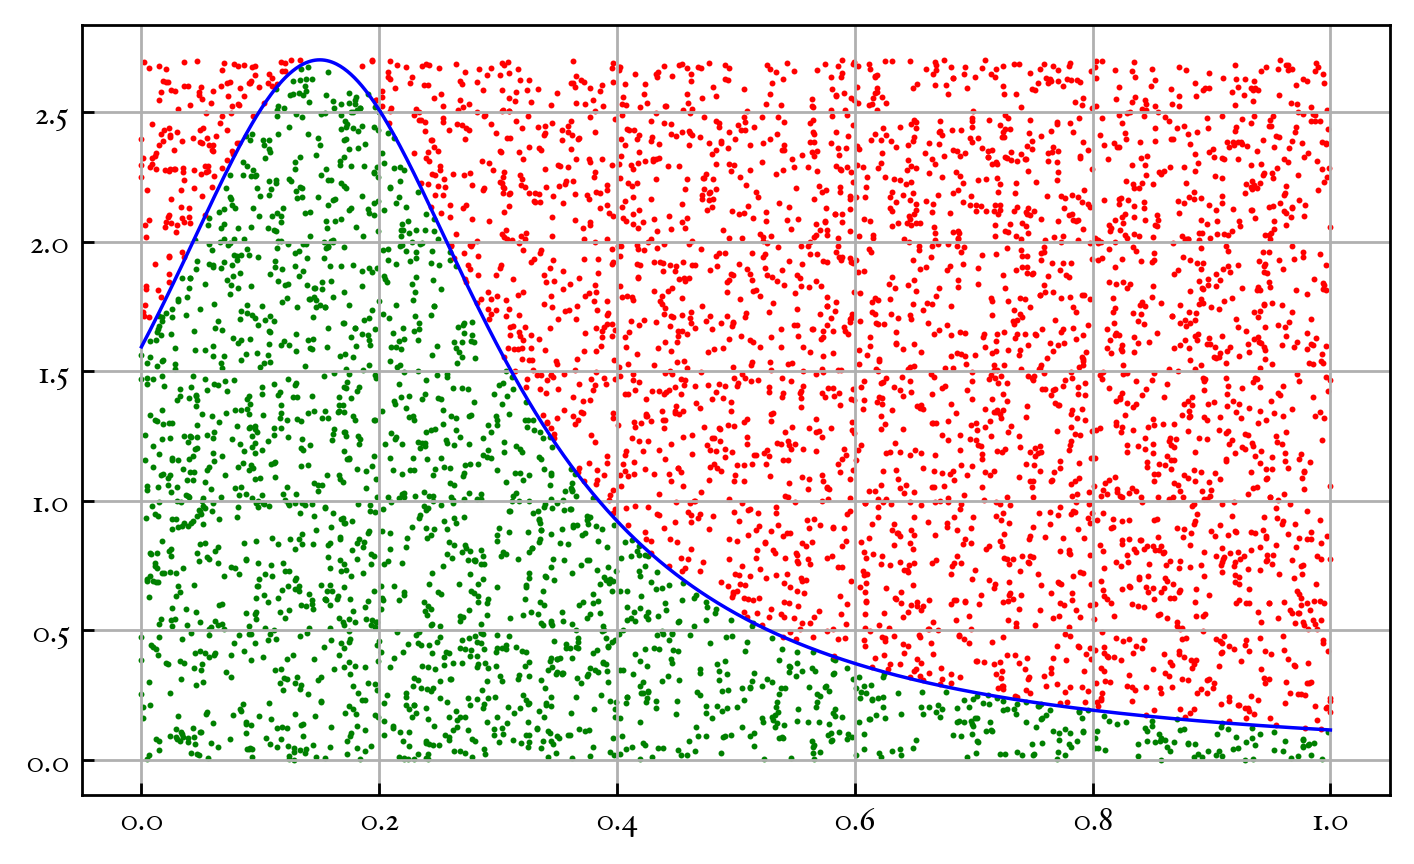

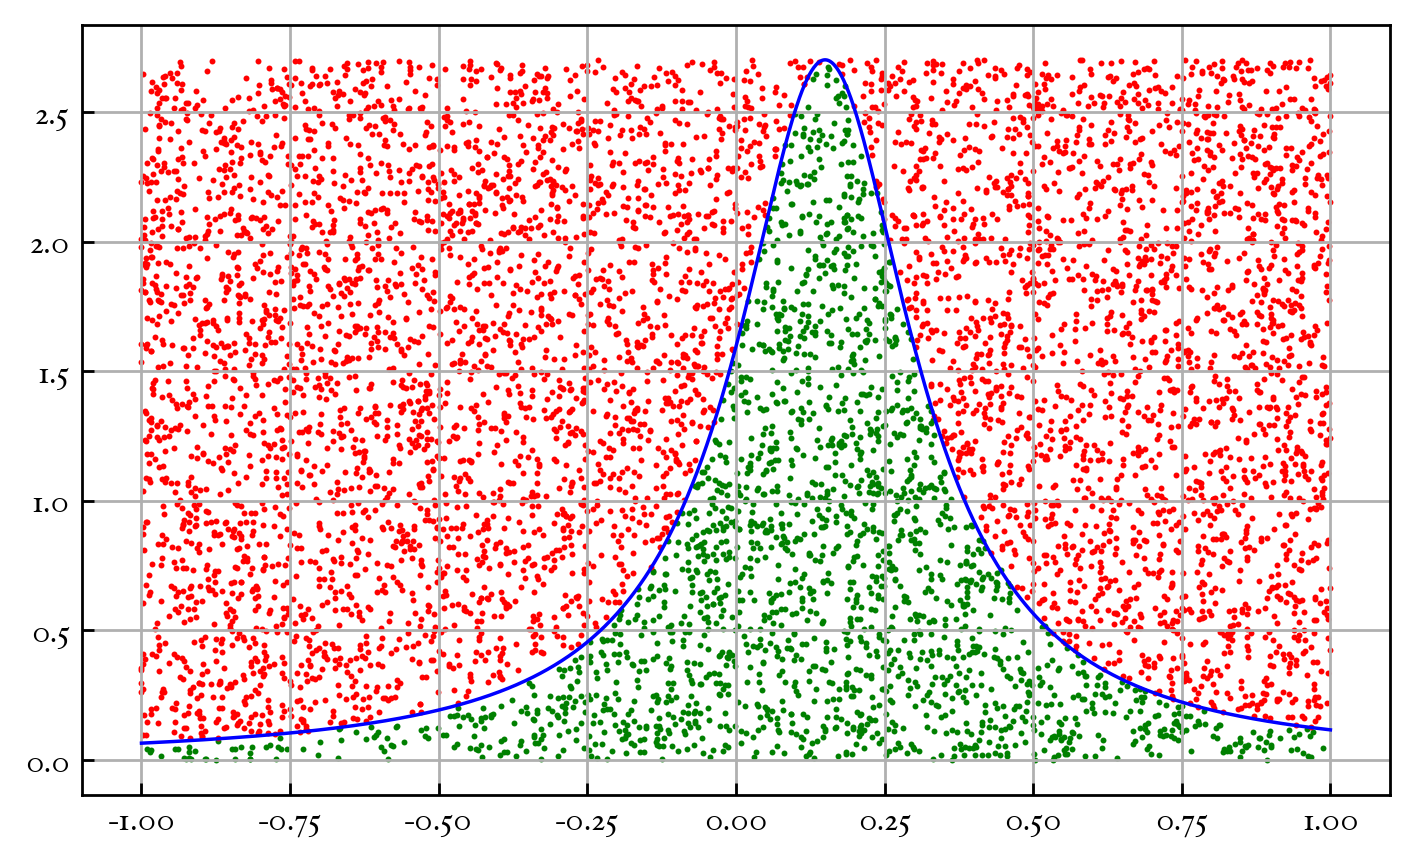

In [5]:
spinPrior = SpinPrior(minimum=0, maximum=1, name='chi_1')
samples = spinPrior.sample(2000)

thetaPrior = SpinPrior(minimum=-1, maximum=1, name='chi_1')
samples = thetaPrior.sample(2000)

In [ ]:
# Standard Prior Dictionary
priors_none = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors_none['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors_none['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors_none['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors_none['chi_1'] = 0
priors_none['chi_2'] = 0
priors_none['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors_none['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors_none['luminosity_distance']
del priors_none['chirp_mass']

priors_uniform = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors_uniform['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors_uniform['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors_uniform['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors_uniform['chi_1'] = bilby.core.prior.Uniform(minimum=-1, maximum=1)
priors_uniform['chi_2'] = bilby.core.prior.Uniform(minimum=-1, maximum=1)
priors_uniform['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors_uniform['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors_uniform['luminosity_distance']
del priors_uniform['chirp_mass']

priors_aligned = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors_aligned['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors_aligned['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors_aligned['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors_aligned['chi_1'] = bilby.gw.prior.AlignedSpin()
priors_aligned['chi_2'] = bilby.gw.prior.AlignedSpin()
priors_aligned['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors_aligned['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors_aligned['luminosity_distance']
del priors_aligned['chirp_mass']

priors_spin = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors_spin['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors_spin['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors_spin['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors_spin['chi_1'] = SpinPrior(minimum=0, maximum=1, name='chi_1')
priors_spin['chi_2'] = SpinPrior(minimum=0, maximum=1, name='chi_2')
priors_spin['cos_theta_1'] = ThetaPrior(minimum=-1, maximum=1, name='cos_theta_1')
priors_spin['cos_theta_2'] = ThetaPrior(minimum=-1, maximum=1, name='cos_theta_2')
priors_spin['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors_spin['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors_spin['luminosity_distance']
del priors_spin['chirp_mass']

In [ ]:
print(priors_none['redshift'].min_limit)

In [ ]:
# Plot Distributions
# Uniform Distribution
fig, ax = plt.subplots()
chi1s = []
chi2s = []
probs1 = []
probs2 = []
for i in range(-100, 100):
    chi1s.append(i*0.01)
    chi2s.append(i*0.01)
    probs1.append(priors_uniform['chi_1'].prob(i*0.01))
    probs2.append(priors_uniform['chi_2'].prob(i*0.01))
ax.plot(chi1s, probs1, color='#ff0000')
ax.plot(chi2s, probs2, color='#0000ff')

# Aligned Distribution
fig, ax = plt.subplots()
chi1s = []
chi2s = []
probs1 = []
probs2 = []
for i in range(-100, 100):
    chi1s.append(i*0.01)
    chi2s.append(i*0.01)
    probs1.append(priors_aligned['chi_1'].prob(i*0.01))
    probs2.append(priors_aligned['chi_2'].prob(i*0.01))
ax.plot(chi1s, probs1, color='#ff0000')
ax.plot(chi2s, probs2, color='#0000ff')

# Realistic Spin Prior from Callister and Farr
fig, ax = plt.subplots()
chis1, pchis1 = SpinPrior()._get_chi_arrays()
chis2, pchis2 = SpinPrior()._get_chi_arrays()
ax.plot(chis1, pchis2, color='#ff0000')
ax.plot(chis2, pchis2, color='#0000ff')

# # p(cos(theta)) Probability Distribution
fig, ax = plt.subplots()
costhetas1, pcosthetas1 = ThetaPrior()._get_theta_arrays()
costhetas2, pcosthetas2 = ThetaPrior()._get_theta_arrays()
ax.plot(costhetas1, pcosthetas1, color='#ff0000')
ax.plot(costhetas2, pcosthetas2, color='#0000ff')

In [ ]:
# Calculate number of injections
def calculate_num_injections(T_obs, priors_none):
    zs, p_dz = priors_none['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    print(p_dz)
    return N

zs, p_dz = priors_none['redshift']._get_redshift_arrays()
N = calculate_num_injections(T_obs, priors_none)
print(N)

In [ ]:
OmegaGWs_none = []
OmegaGWs_uniform = []
OmegaGWs_aligned = []
OmegaGWs_spin = []

for i in range(num_iterations):
    freqs_psd_none, omega_gw_freq_none, injections_none = sample_dict_compute_injected_omega(priors_none, Tobs=T_obs, duration=1, f_ref=50, sampling_frequency=2048,
                                       approximant='IMRPhenomD')
    freqs_psd_uniform, omega_gw_freq_uniform, injections_uniform = sample_dict_compute_injected_omega(priors_uniform, Tobs=T_obs, duration=1, f_ref=50, sampling_frequency=2048,
                                       approximant='IMRPhenomD')
    freqs_psd_aligned, omega_gw_freq_aligned, injections_aligned = sample_dict_compute_injected_omega(priors_aligned, Tobs=T_obs, duration=1, f_ref=50, sampling_frequency=2048,
                                       approximant='IMRPhenomD')
    # freqs_psd_spin, omega_gw_freq_spin, injections_spin = sample_dict_compute_injected_omega(priors_spin, Tobs=T_obs, duration=1, f_ref=50, sampling_frequency=2048,
    #                                    approximant='IMRPhenomD')

    # fig, ax = plt.subplots()
    # ax.hist(injections_none['chi_1'], color='#ff0000')
    # ax.hist(injections_none['chi_2'], color='#0000ff')
    # ax.hist(injections_uniform['chi_1'], color='#ff0000')
    # ax.hist(injections_uniform['chi_2'], color='#0000ff')
    # ax.hist(injections_aligned['chi_1'], color='#ff0000')
    # ax.hist(injections_aligned['chi_2'], color='#0000ff')
    # ax.hist(injections_spin['chi_1'], color='#ff0000')
    # ax.hist(injections_spin['chi_2'], color='#0000ff')

    OmegaGWs_none.append(omega_gw_freq_none)
    OmegaGWs_uniform.append(omega_gw_freq_uniform)
    OmegaGWs_aligned.append(omega_gw_freq_aligned)
    # OmegaGWs_spin.append(omega_gw_freq_spin)

In [ ]:
def find_min_and_max_spectrum(spectra):
    min_value = 1.0
    max_value = 0.0
    min_spectrum = spectra[0]
    max_spectrum = spectra[0]
    for i in range(len(spectra)):
        if max(spectra[i]) < min_value:
            min_value = max(spectra[i])
            min_spectrum = spectra[i]
        if max(spectra[i]) > max_value:
            max_value = max(spectra[i])
            max_spectrum = spectra[i]
    return min_spectrum, max_spectrum

def average_spectra(spectra):
    return np.average(spectra, axis=0)


In [ ]:
min_none, max_none = find_min_and_max_spectrum(OmegaGWs_none)
min_uniform, max_uniform = find_min_and_max_spectrum(OmegaGWs_uniform)
min_aligned, max_aligned = find_min_and_max_spectrum(OmegaGWs_aligned)
# min_spin, max_spin = find_min_and_max_spectrum(OmegaGWs_spin)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
# Plot all iterations
# for i in range(num_iterations):
    # ax.loglog(freqs_psd_none, OmegaGWs_none[i], color='#ff0000')
    # ax.loglog(freqs_psd_uniform, OmegaGWs_uniform[i], color='#00ff00')
    # ax.loglog(freqs_psd_aligned, OmegaGWs_aligned[i], color='#0000ff')
    # ax.loglog(freqs_psd_spin, OmegaGWs_spin[i], color='#ffff00')

# Plot range for each spin distribution
ax.fill_between(freqs_psd_none, min_none, max_none, color='#ff0000', alpha=0.3)
ax.fill_between(freqs_psd_uniform, min_uniform, max_uniform, color='#00ff00', alpha=0.3)
ax.fill_between(freqs_psd_aligned, min_aligned, max_aligned, color='#0000ff', alpha=0.3)
# ax.fill_between(freqs_psd_none, min_none, max_none, color='#ffff00')

# Plot average for each spin distribution
# ax.loglog(freqs_psd_none, average_spectra(OmegaGWs_none), color='#ff0000')
# ax.loglog(freqs_psd_uniform, average_spectra(OmegaGWs_uniform), color='#00ff00')
# ax.loglog(freqs_psd_aligned, average_spectra(OmegaGWs_aligned), color='#0000ff')
# ax.loglog(freqs_psd_aligned, average_spectra(OmegaGWs_spin), color='#0000ff')

ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 2048)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-10, 1e-8)
ax.legend()

In [ ]:
def findChiEff(chi1, chi2, theta1, theta2, q):
    return (chi1*math.cos(theta1) + q*chi2*math.cos(theta2))/(1 + q)

In [ ]:
# Chi/Chi_eff Distribution
# chi1s = injections_spin['chi_1']
# chi2s = injections_spin['chi_2']
# costheta1s = injections_spin['cos_theta_1']
# costheta2s = injections_spin['cos_theta_2']
# qs = injections_spin['mass_ratio']
# chiEffs = []
# for injection in injections_spin:
#     chiEff = (chi1s[i]*costheta1s[i] + qs[i]*chi2s[i]*costheta2s[i])/(1 + qs[i])
#     chiEffs.append(chiEff)

# fig, ax = plt.subplots()
# ax.plot(chi1s, chiEffs, color='#ff0000', label=r'$\chi_1$')
# ax.plot(chi2s, chiEffs, color='#0000ff', label=r'$\chi_2$')
# ax.set_xlabel(r'$\chi$')
# ax.set_ylabel(r'$\chi_{eff}$')

# fig, ax = plt.subplots()
# ax.hist(chi1s/chiEffs, color='#ff0000', label=r'$\chi_1$')
# ax.hist(chi2s/chiEffs, color='#0000ff', label=r'$\chi_2$')
# ax.set_xlabel(r'$\chi$')
# ax.set_ylabel(r'$\chi_{eff}$')